# Model Selection<br><sub>and Information Sharing and Information Criterion</sub>


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy import integrate
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from scipy.stats import rankdata
import pytensor.tensor as pt
from scipy.stats import expon, multivariate_normal, norm
from sklearn.preprocessing import StandardScaler

# Week 11 Homework (9)

### Q1: copulas

1. Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find** (skip)


2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

In [3]:
df1 = pd.read_csv('austin_weather.csv')
print(df1.columns.tolist())
df1[['DewPointAvgF', 'HumidityAvgPercent', 'WindAvgMPH', 'PrecipitationSumInches']] = df1[['DewPointAvgF', 'HumidityAvgPercent', 'WindAvgMPH', 'PrecipitationSumInches']].apply(pd.to_numeric, errors='coerce')

['Date', 'TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent', 'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches', 'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH', 'WindGustMPH', 'PrecipitationSumInches', 'Events']


In [10]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.rcParams.update({"font.size": 14, "figure.constrained_layout.use": False})
SEED = 43
rng = np.random.default_rng(SEED)

In [11]:
data = df1[['TempAvgF', 'HumidityAvgPercent']].dropna().to_numpy()
a = data[:, 0]  # Temp
b = data[:, 1]  # Humidity

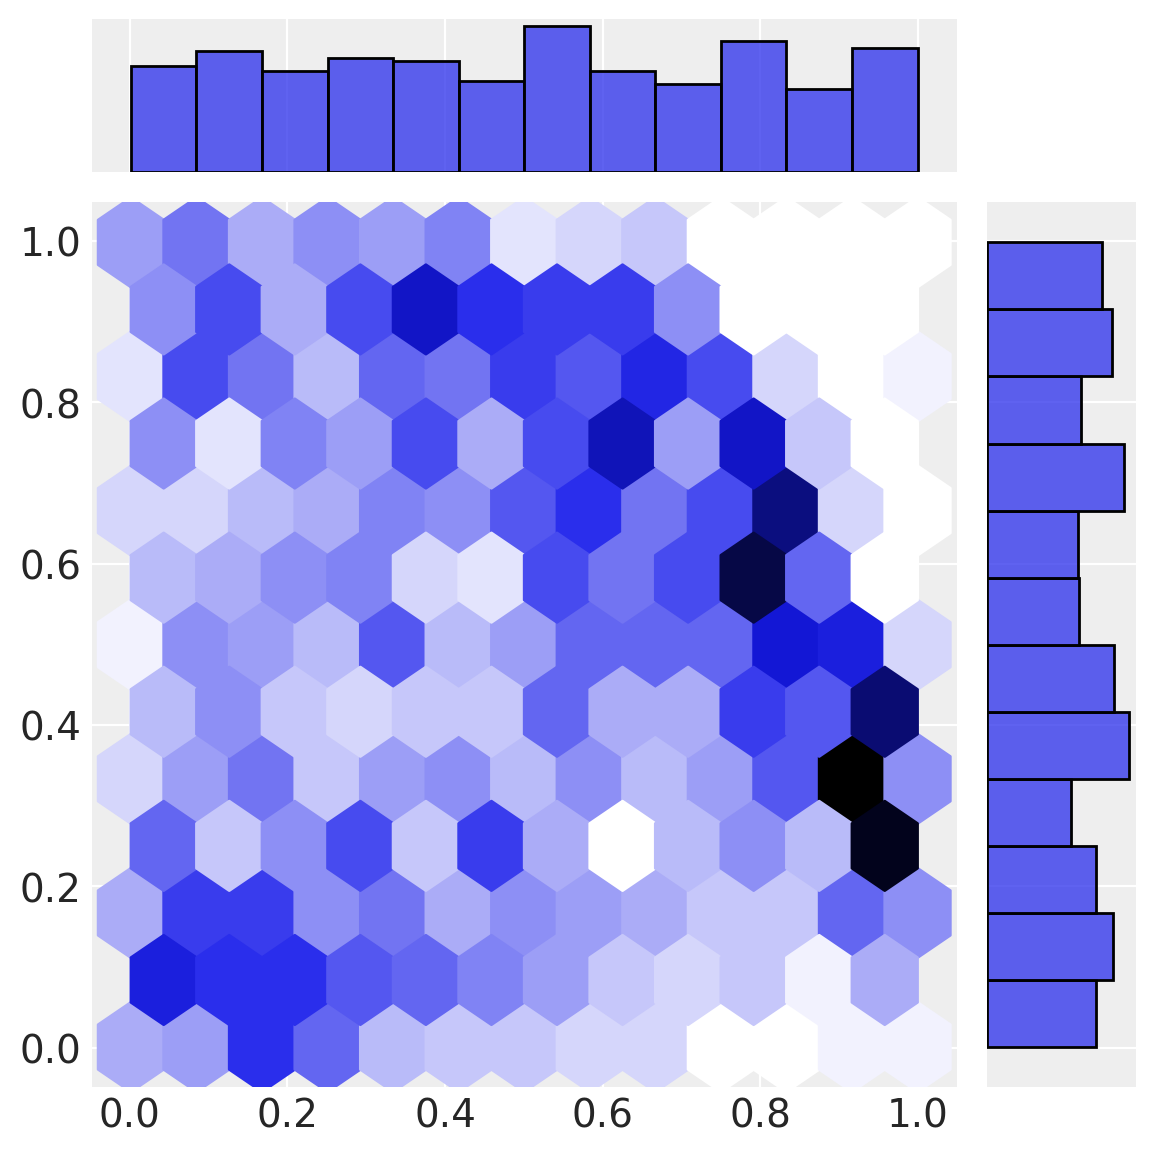

In [15]:
a_unif = rankdata(a) / (len(a) + 1)
b_unif = rankdata(b) / (len(b) + 1)
sns.jointplot(x=a_unif, y=b_unif, height=6, kind="hex")

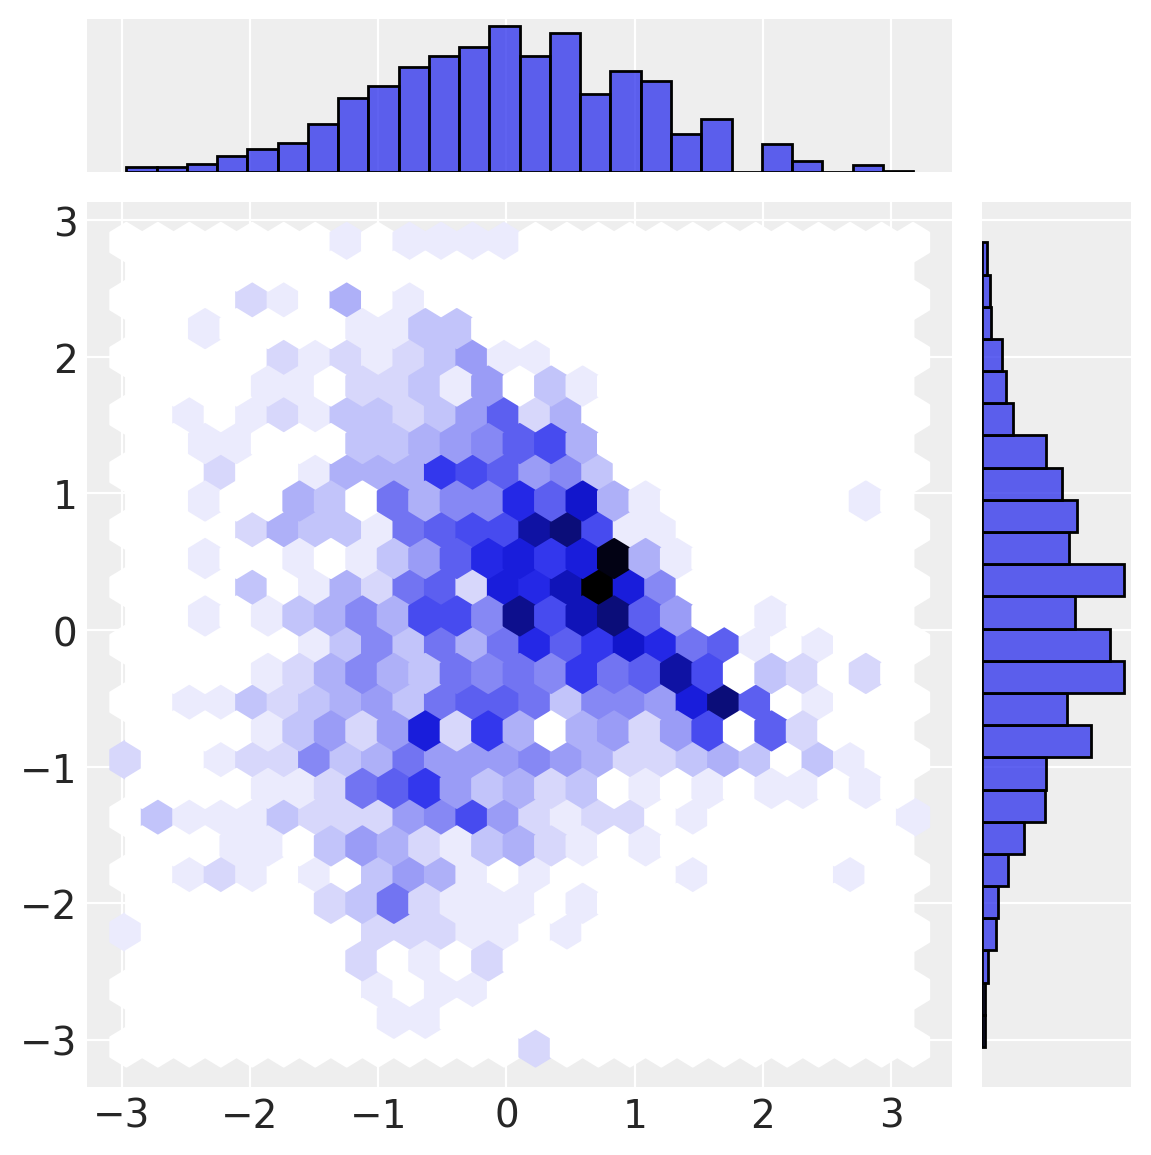

In [16]:
a2 = norm.ppf(a_unif)
b2 = norm.ppf(b_unif)
sns.jointplot(x=a2, y=b2, kind="hex", height=6)


In [20]:
df_clean = df1[['TempAvgF', 'HumidityAvgPercent']].dropna()
a = df_clean['TempAvgF'].values
b = df_clean['HumidityAvgPercent'].values
coords = {"obs_id": np.arange(len(a))}

coords = {"obs_id": np.arange(len(a))}
with pm.Model(coords=coords) as marginal_model:
    """
    Assumes observed data in variables `a` and `b`
    """
    # marginal estimation
    a_mu = pm.Normal("a_mu", mu=0, sigma=1)
    a_sigma = pm.Exponential("a_sigma", lam=0.5)
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=a, dims="obs_id")

    b_scale = pm.Exponential("b_scale", lam=0.5)
    pm.Exponential("b", lam=1 / b_scale, observed=b, dims="obs_id")

#pm.model_graph.model_to_graphviz(marginal_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, b_scale]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


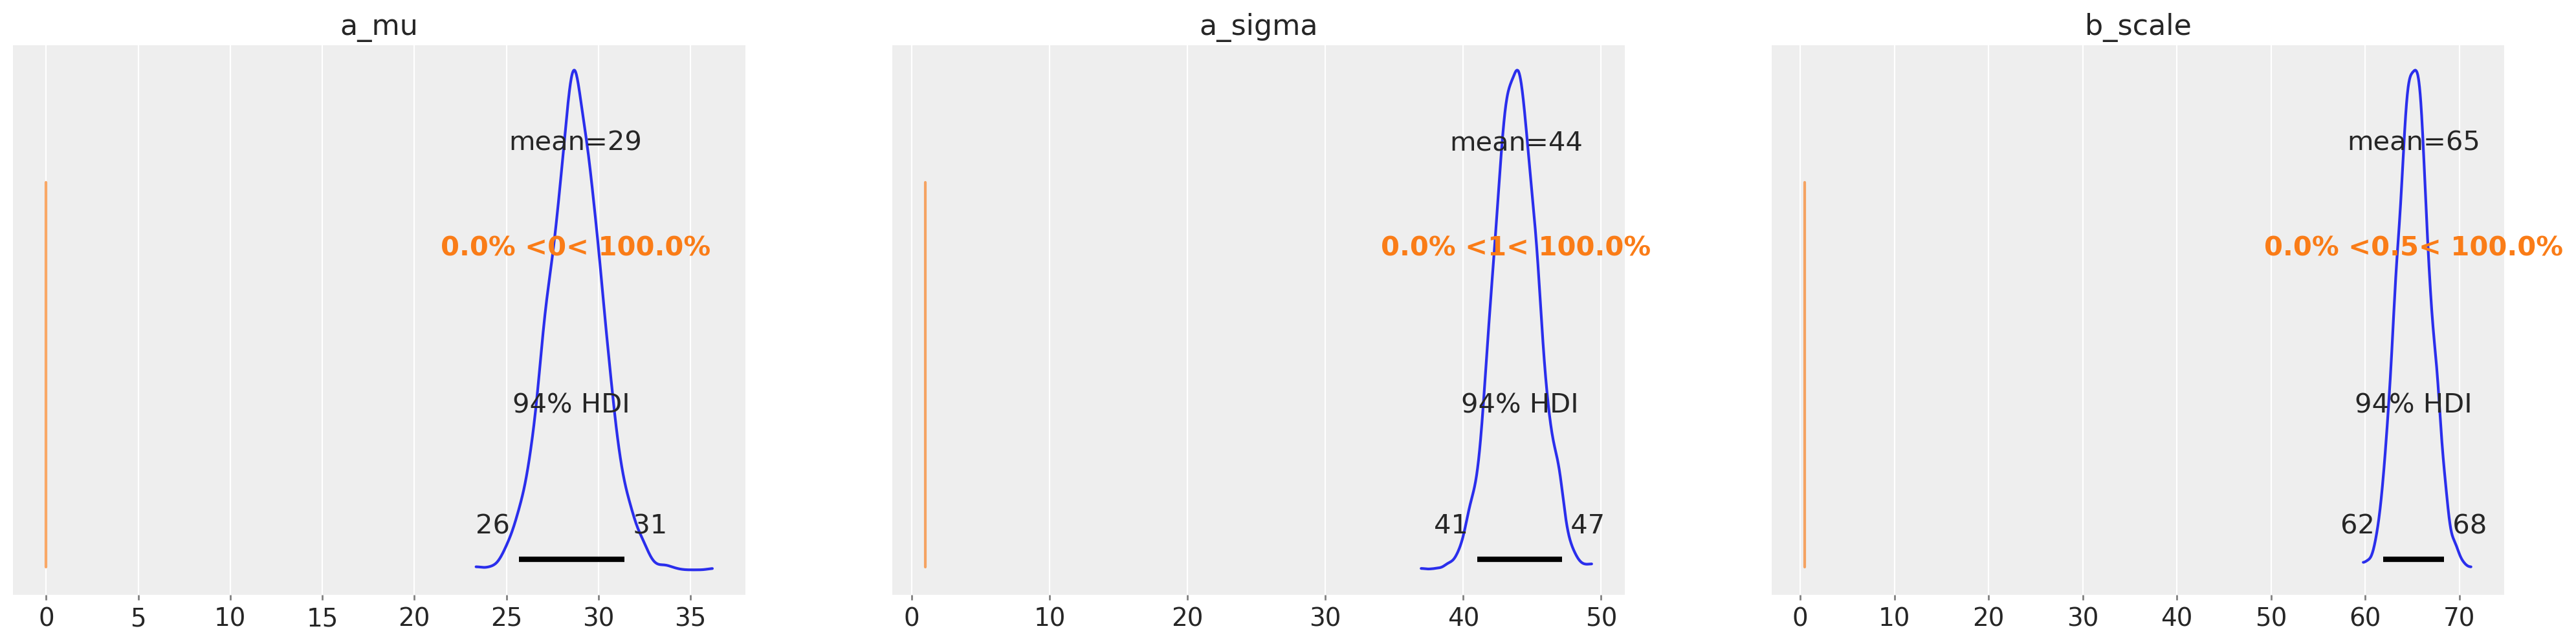

In [21]:

with marginal_model:
    marginal_idata = pm.sample(random_seed=rng)

az.plot_posterior(
    marginal_idata, var_names=["a_mu", "a_sigma", "b_scale"], ref_val=[0, 1.0, 1 / 2.0]
);

In [24]:
def transform_data(marginal_idata):
    # point estimates
    a_mu = marginal_idata.posterior["a_mu"].mean().item()
    a_sigma = marginal_idata.posterior["a_sigma"].mean().item()
    b_scale = marginal_idata.posterior["b_scale"].mean().item()
    # transformations from observation space -> uniform space
    __a = pt.exp(pm.logcdf(pm.Normal.dist(mu=a_mu, sigma=a_sigma), a))
    __b = pt.exp(pm.logcdf(pm.Exponential.dist(lam=1 / b_scale), b))
    # uniform space -> multivariate normal space
    _a = pm.math.probit(__a)
    _b = pm.math.probit(__b)
    # join into an Nx2 matrix
    data = pt.math.stack([_a, _b], axis=1).eval()
    return data, a_mu, a_sigma, b_scale


data, a_mu, a_sigma, b_scale = transform_data(marginal_idata)

In [26]:
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))

# pm.model_graph.model_to_graphviz(copula_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [chol]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 49 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'cov\na, a'}>,
       <Axes: title={'center': 'cov\na, b'}>,
       <Axes: title={'center': 'cov\nb, a'}>,
       <Axes: title={'center': 'cov\nb, b'}>], dtype=object)

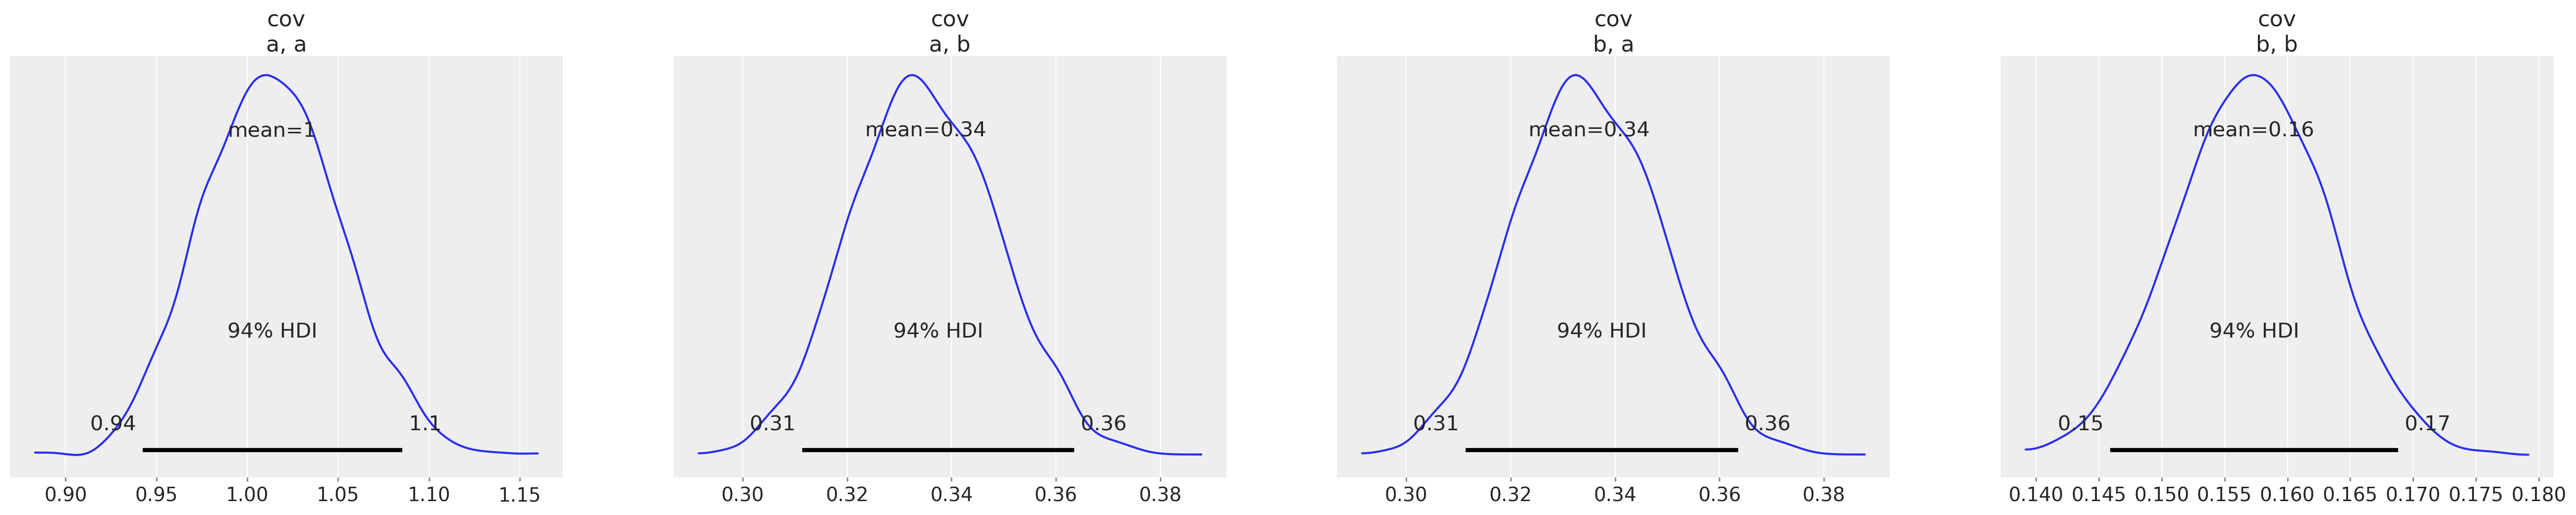

In [28]:
with copula_model:
    copula_idata = pm.sample(random_seed=rng, tune=2000, cores=1)

az.plot_posterior(copula_idata, var_names=["cov"])

In [31]:
# data munging to extract covariance estimates from copula_idata in useful shape
d = {k: v.values.reshape((-1, *v.shape[2:])) for k, v in copula_idata.posterior[["cov"]].items()}

# generate (a, b) samples
ab = np.vstack([multivariate_normal([0, 0], cov).rvs() for cov in d["cov"]])

# transform to uniform space
uniform_a = norm().cdf(ab[:, 0])
uniform_b = norm().cdf(ab[:, 1])

# transform to observation space
# estimated marginal parameters a_mu, a_sigma, b_scale are point estimates from marginal estimation.
ppc_a = norm(loc=a_mu, scale=a_sigma).ppf(uniform_a)
ppc_b = expon(scale=b_scale).ppf(uniform_b)

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(x_x, y_y, density, **contour_kwargs)


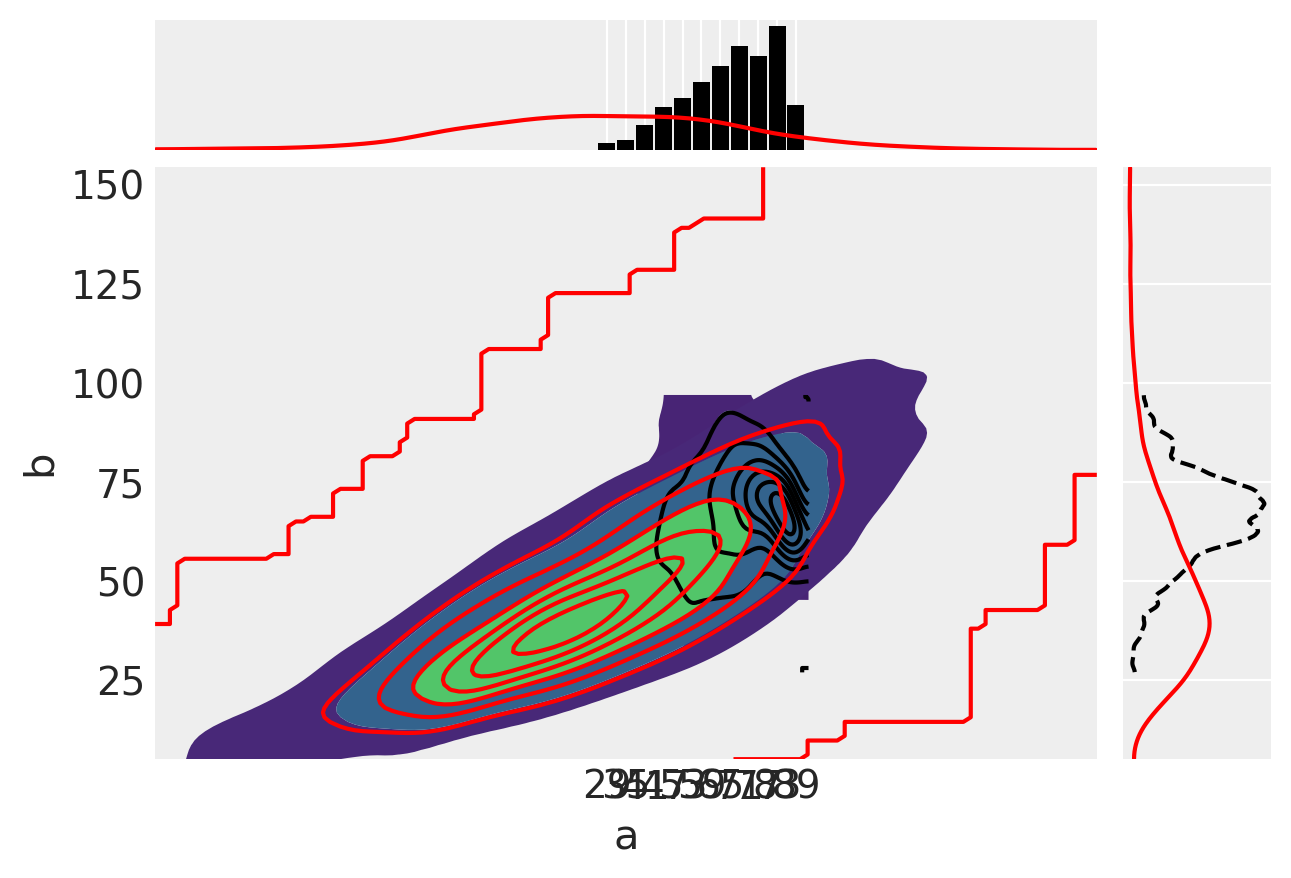

In [32]:
# plot data in black
ax = az.plot_pair(
    {"a": a, "b": b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.1},
    kde_kwargs=dict(
        contour_kwargs=dict(colors="k", linestyles="--"), contourf_kwargs=dict(alpha=0)
    ),
    marginal_kwargs=dict(color="k", plot_kwargs=dict(ls="--")),
)

# plot inferences in red
axs = az.plot_pair(
    {"a": ppc_a, "b": ppc_b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.01},
    kde_kwargs=dict(contour_kwargs=dict(colors="r", linestyles="-"), contourf_kwargs=dict(alpha=0)),
    marginal_kwargs=dict(color="r"),
    ax=ax,
);

### Describe what a copula is and how the two verions of code implement it

Copula is used to model the dependency between multiple random variables separate from individual distribution.

Compare the two versions of code

one-pass model (code below from lecture):
* jointly estimated all marginal distributions and the copulas in one PyMC model
* used transformed latent variables and multivariate normal likelihood

two-pass model (above code): 
* we estimated temperature and humidity marginals separately
* then we tarnsformed the data and fit a Gaussian copula to model their independence
* we had a marginal model and copula model

one-pass is better because it estimates everythign together in one model so the marginals and the dependence impacts each other
this makes the result more accurate and consistent 

### Describe how to use this to create arbitrary multivariate GLM regressions

think about how you would create a multivariate arbitrary marginal GLM using the two versions of the copula, and which most fully explores the full variability of parameter uncertainty in its posterior estimation. Answering this correctly essentially provides the comparison that subquestion 3 is asking for.

One-pass:
* marginal GLMs will be in one model
* each would be modelled with its own regression
* latent transformation to map marginal to standard normal
* jointly model transformd variables with a multivariate normal copula 
* full joint captures all uncertainty 
* one pass is better because it does everything together 

Two-pass:
* fit a separate GLM for each marginal v
* use the posterior predictive distri to transform each marginal to uniform then to standard normal
* fit the copula 
* this would capture the marginals well but when fitting the copula the mean is being used so it ignores uncertainty



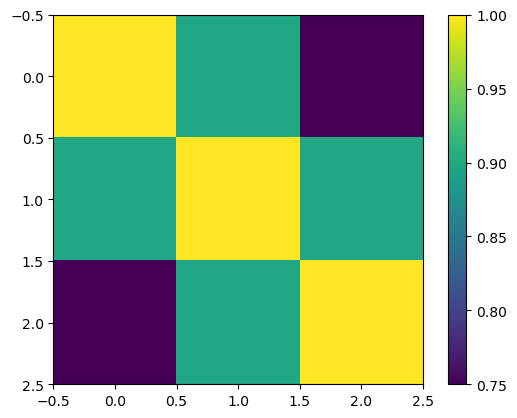

In [89]:
p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


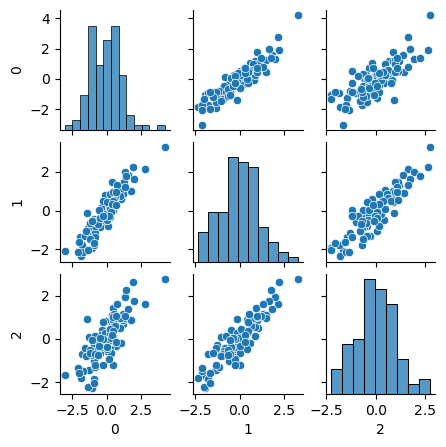

In [90]:
seaborn.pairplot(pd.DataFrame(x),height=1.5);

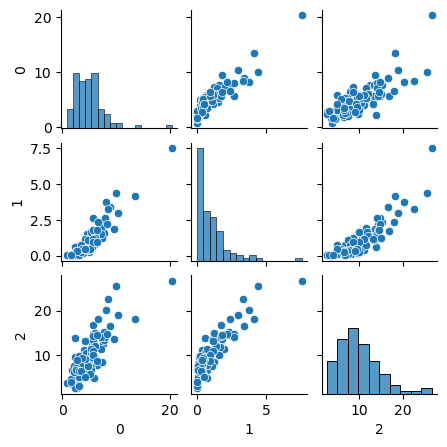

In [91]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [129]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)), 
                           mu=0, sigma=1))
    
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)), 
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_', 
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)), 
                           mu=0, sigma=1))
    
    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=3), 
                                 compute_corr=True)
    
    potential = pm.Potential("MVNeval", 
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))
    
    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1, p2, R]


/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not

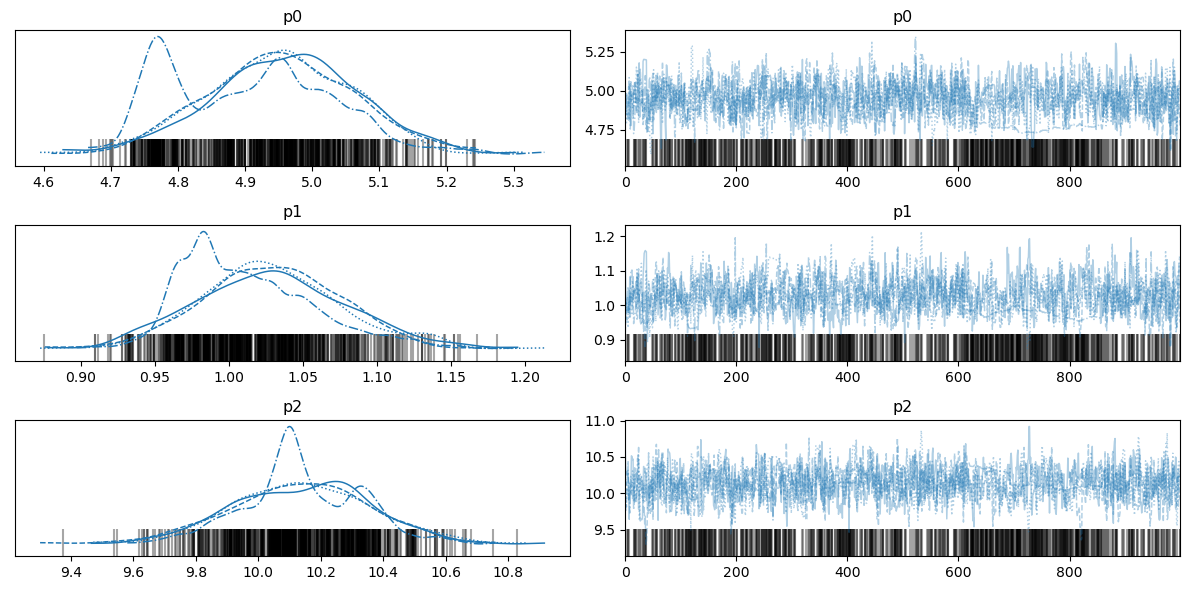

In [134]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

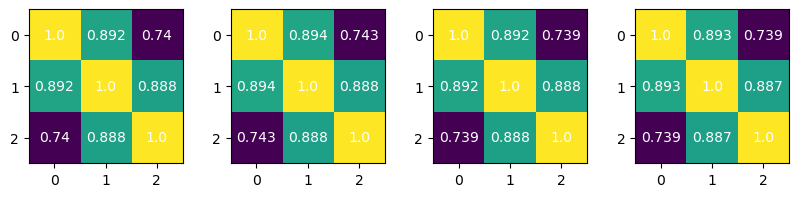

In [154]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)), 
                       color='w', va='center', ha='center')

# Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [11]:
n = 100
predictors = np.random.normal(size=(n, 4))  # 4 predictors
targets = np.random.normal(size=(n, 3))  # 3 targets
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

In [6]:
# Spike-and-slab model
with pm.Model() as model:

    slab = pm.Normal.dist(mu=0, sigma=1)  
    spike = pm.Normal.dist(mu=0, sigma=0.001)  
    
    betas = pm.Mixture('betas', w=[0.95, 0.05], comp_dists=[spike, slab], shape=(4, 3))
    
    intercept = pm.Normal('intercept', mu=0, sigma=0.1, shape=3)
    mu = pm.math.dot(predictors_scaled, betas) + intercept
    likelihood = pm.Normal('y', mu=mu, sigma=1, observed=targets)
    
    trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
# Diffuse normal model
with pm.Model() as model_diffuse:
    betas = pm.Normal('betas', mu=0, sigma=10, shape=(4, 3))
    intercept = pm.Normal('intercept', mu=0, sigma=0.1, shape=3)
    mu = pm.math.dot(predictors_scaled, betas) + intercept
    likelihood = pm.Normal('y', mu=mu, sigma=1, observed=targets)
    trace_diffuse = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

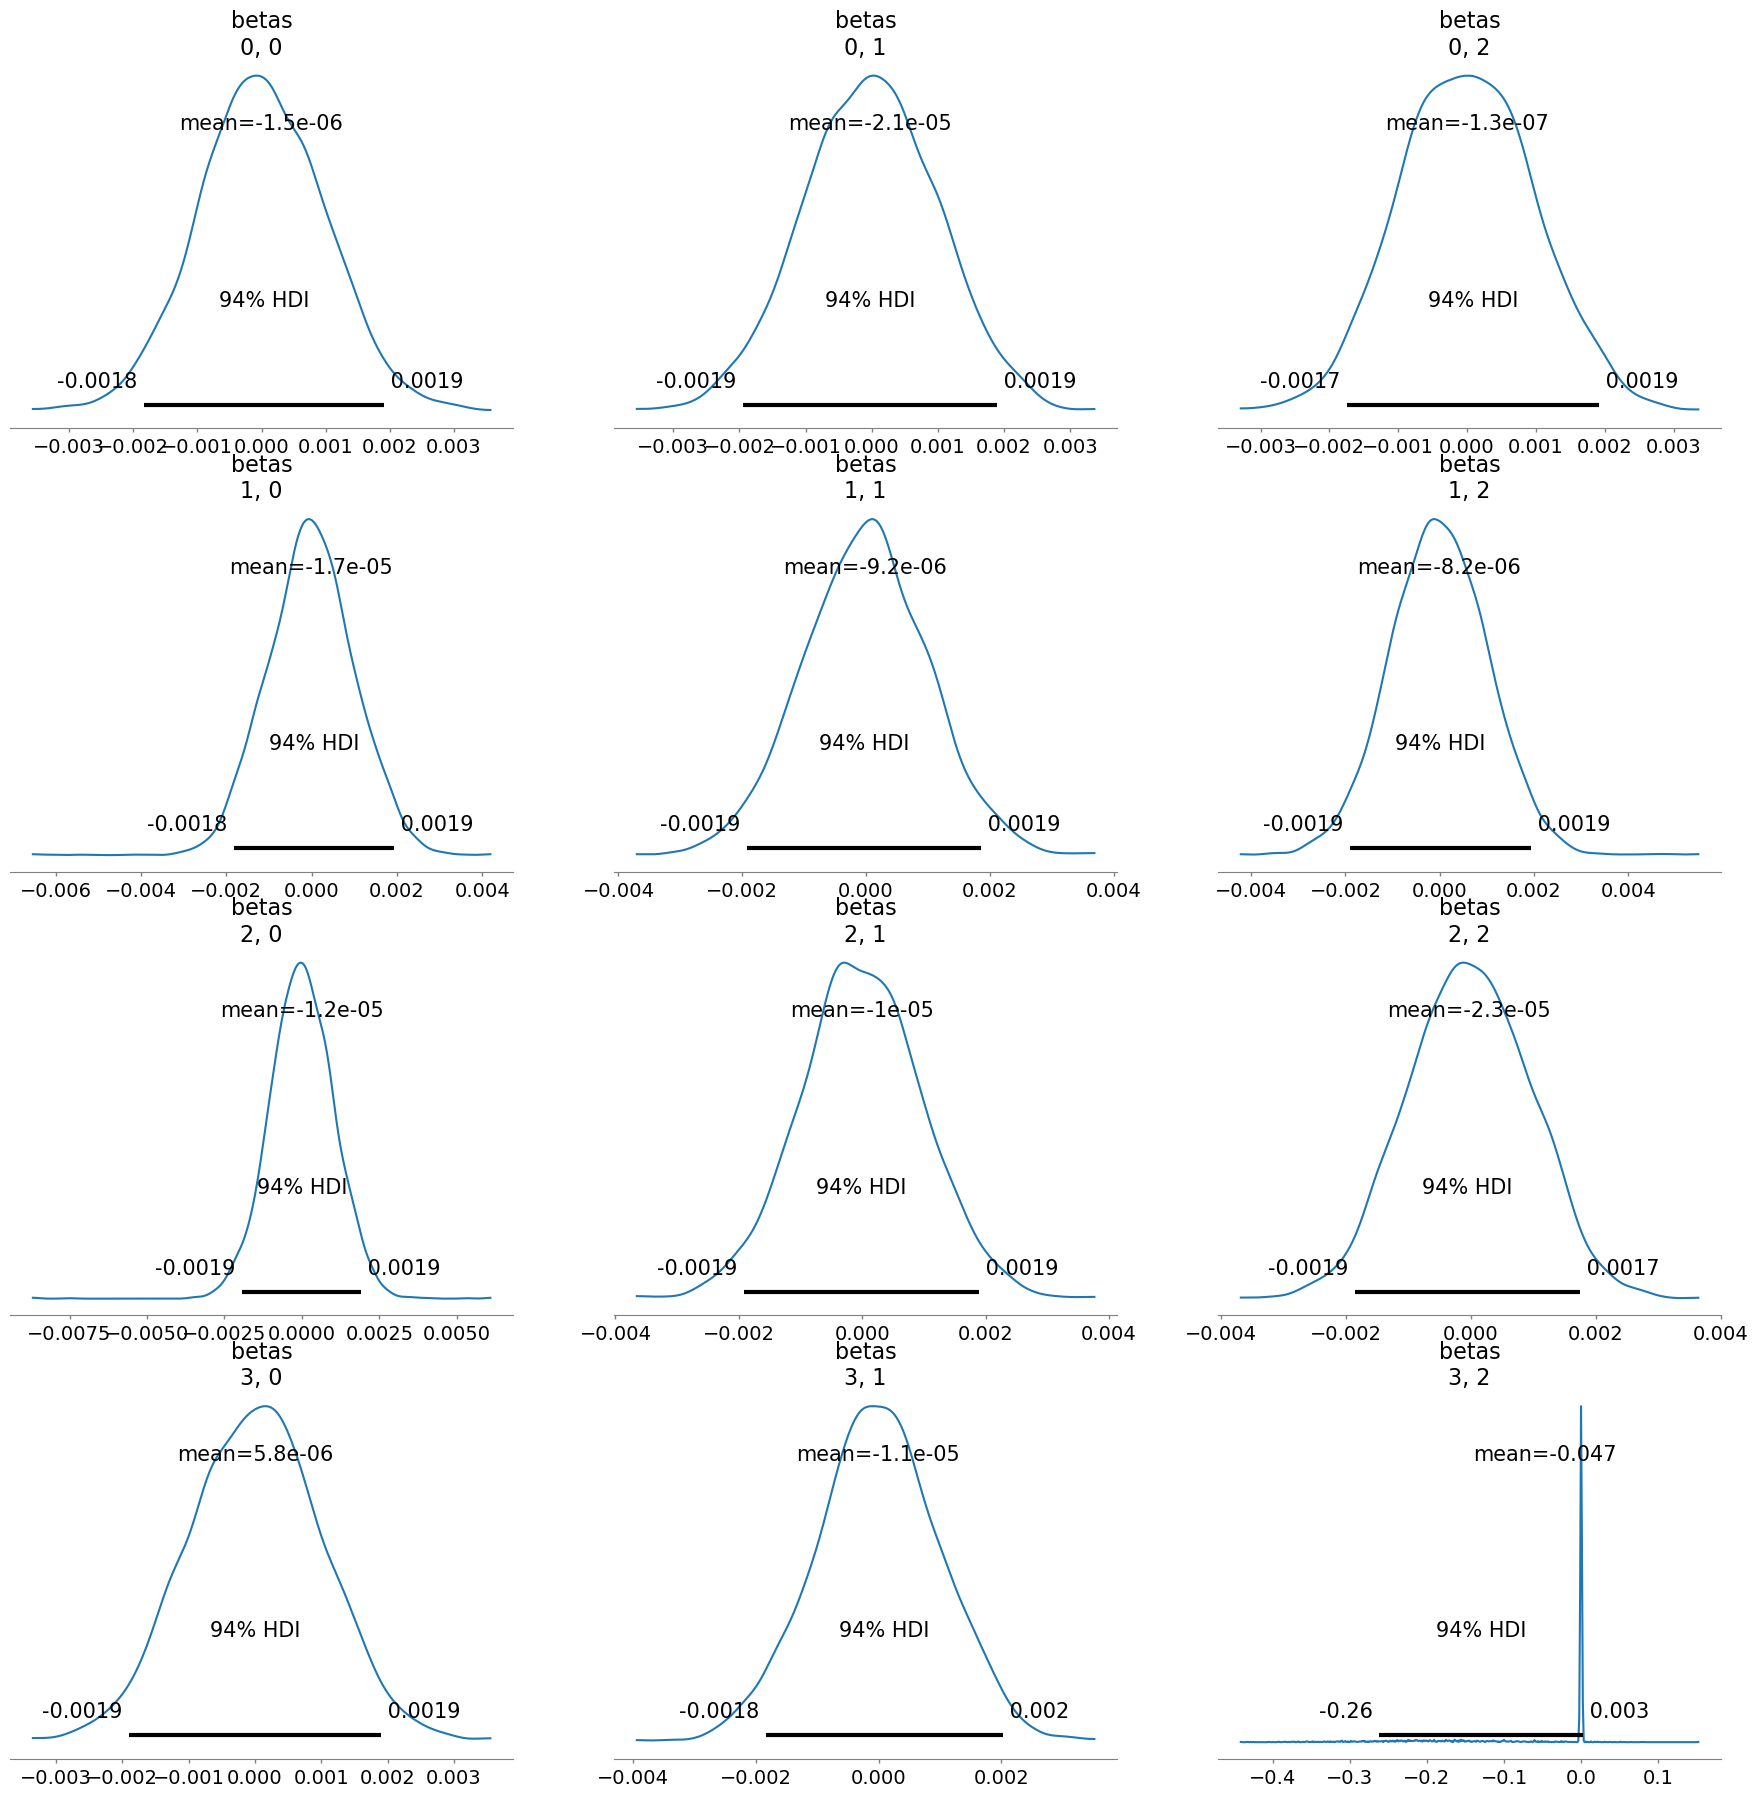

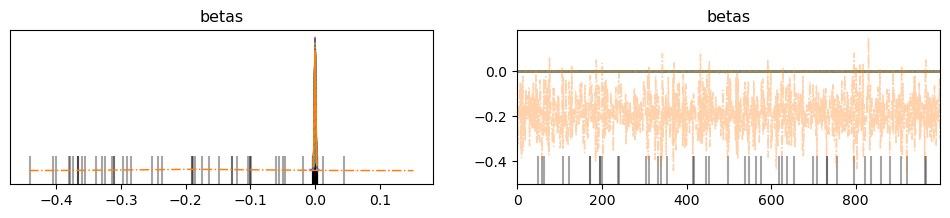

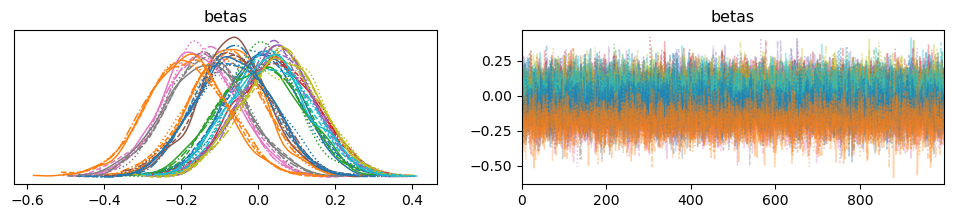

In [10]:
az.plot_posterior(trace, var_names=['betas'])
az.plot_trace(trace, var_names=['betas'])
az.plot_trace(trace_diffuse, var_names=['betas'])


spike slab model:
* many coefficients are close to zero - sparsity
* horizontal line at 0 in trace plot - those coefficients shrunk to zero
* shows variable selection - only some predictors are significant but in this case all shrunk to zero
* the orange line in the trace plot is for initial exploration 
* looking at plot posterior the distributions are very close to zero


diffused
* posterior distribution of the coefficients is spread out
* trace plot don't show sparsity and and show expected behaviour for normal prior
* no explicit zeros

# Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



In [2]:
n, p, m = 100, 4, 3

predictors = np.random.normal(size=(n, p))  # 100 samples, 4 predictors
targets = np.random.normal(size=(n, m))  # 100 samples, 3 target variables

# Standardize the predictors
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

In [4]:

# Horseshoe model
with pm.Model() as horseshoe_model:
    tau = pm.HalfNormal('tau', sigma=0.1)  
    lambda_ = pm.HalfNormal('lambda_', sigma=1, shape=(p, m))  
    betas = pm.Normal('betas', mu=0, sigma=tau * lambda_, shape=(p, m)) 
    intercept = pm.Normal('intercept', mu=0, sigma=0.1, shape=m)  
    mu = pm.math.dot(predictors_scaled, betas) + intercept  
    likelihood = pm.Normal('y', mu=mu, sigma=1, observed=targets)  
    
    trace_horseshoe = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda_, betas, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 755 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

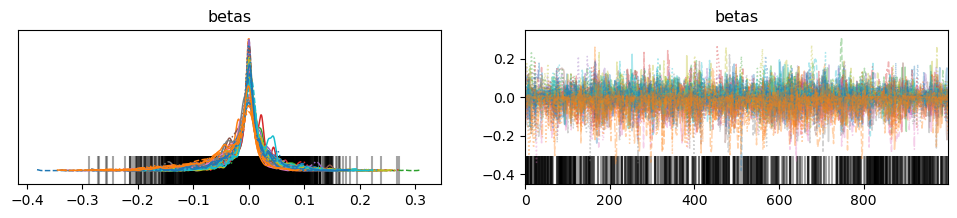

In [5]:
az.plot_trace(trace_horseshoe, var_names=['betas'])

Spike-Slab (Q2)
* distribution of beta is more sparse - sharp spike at zero 
* trace plot shows coef very close to 0 
* variable selection by setting coef to very close to zero (good when a lot of coef that have minimal impact)

Horseshoe
* distribution is less sparse/wider, still concentrating near 0
* more coefficients that have non-zero values, some are shrunk to zero
* fluctuate around zero, less sharp than spike-slab as it's not a straight line
* variable shrinking but not setting to zero (good for flexibility, not discarding coef completely)

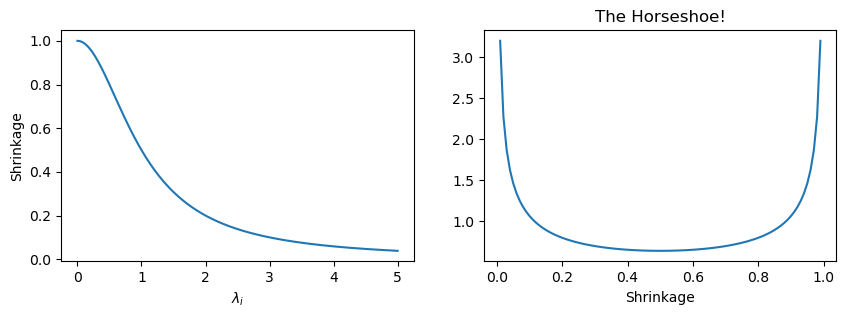

In [156]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$") 
# change of variables: 
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage, 
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");